In [1]:
import torch
torch.cuda.current_device()

import pickle
torch.set_default_dtype(torch.float64)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append("../..")

from prediction.evaluation import compute_rNMSEs_per_step, compute_iteration_rNMSE
from prediction.pred_utils import get_device, transform_data_to_all_steps_prediction, \
    convert_data_to_graph_time_pr_graph, get_name_string, get_dataset

from architectures.space_time.parametric_pooling_net import ParametricNetWithPooling

from utils.graph_utils import permutation_by_degree

device = get_device(use_gpu=True)

Device selected: cuda:0


# --------------------------------------------------------------------------------------

# Loading the data

In [2]:
ds_name = 'NOAA'
NORMALIZE_ADJACENCY_MATRIX = True
ds_folder=r"../../prediction/"

dataset, observation_window, N_spatial_nodes, steps_ahead, perm_weighted_adj, order, in_sample_means = get_dataset(
    ds_name,
    ds_folder,
    NORMALIZE_ADJACENCY_MATRIX
)
print(f"{N_spatial_nodes} nodes - {observation_window} observed timesteps - steps ahead: {steps_ahead}")



NOAA is selected


109 nodes - 4 observed timesteps - steps ahead: [1, 2, 3, 4, 5]


In [3]:
# Get data (We do not need test data/labels here)
_, _, tst_data, _, _, tst_labels = transform_data_to_all_steps_prediction(dataset, device, order)

print(tst_data.shape, tst_labels.shape)

# convert time-varying data to graph-time product graph
gt_tst_data = convert_data_to_graph_time_pr_graph(tst_data)
print(gt_tst_data.shape)

torch.Size([1744, 4, 109]) torch.Size([1744, 5, 109])
torch.Size([1744, 1, 436])


# Create the model
This must match the model we are going to load from the checkpoint

In [4]:
runs_dir = "C:\\Users\\gabri\\Desktop\\experiment_prediction_NOAA\\runs_NOAA_27_january\\"
model_name = "20200126092547_1step-GTCNN_lr=0.005_b=128_L=2_F=[8, 8]_T=[2, 2]_P=[2, 2]_R=[1, 1]_N=[109, 54]"
model_path = runs_dir + model_name
model_path

'C:\\Users\\gabri\\Desktop\\experiment_prediction_NOAA\\runs_NOAA_27_january\\20200126092547_1step-GTCNN_lr=0.005_b=128_L=2_F=[8, 8]_T=[2, 2]_P=[2, 2]_R=[1, 1]_N=[109, 54]'

In [5]:
feat_per_layer = [1, 8, 8]
taps_per_layer = [2, 2]
active_nodes_per_timestep_per_layer = [N_spatial_nodes, 109, 54]
time_pooling_ratio_per_layer = [2, 2]
pool_reach_per_layer = [1, 1]


one_step_gtcnn = ParametricNetWithPooling(
    window=observation_window,
    S_spatial=perm_weighted_adj,
    n_feat_per_layer=feat_per_layer,
    n_taps_per_layer=taps_per_layer,
    n_active_nodes_per_timestep_per_layer=active_nodes_per_timestep_per_layer,
    time_pooling_ratio_per_layer=time_pooling_ratio_per_layer,
    pool_reach_per_layer=pool_reach_per_layer,
    output_dim=N_spatial_nodes,
    device=device)

one_step_gtcnn.to(device)
print(one_step_gtcnn)



[ParametricNetWithPooling]. Initialization started.
Window is: 4
N. nodes in spatial graph: 109
Timesteps per layer: [4, 2, 1]
N. active nodes per timestep per layer: [109, 109, 54]
N. of active nodes per layer: [436, 218, 54]
[ParametricNetWithPooling]. Initialization completed.
ParametricNetWithPooling(
  (GFL): Sequential(
    (0): ParametricGraphFilter(in_features=1, out_features=8, filter_taps=2, edge_features=1, timesteps= 4, h_00= 1.0, h_01= 1.0, h_10= 1.0, h_11= 1.0, # params= 28)
    (1): ReLU()
    (2): SpaceTimeMaxPooling(nodes_in=436, nodes_out=218, hops=1, steps_in=4, steps_out=2, tot_st_nodes=436, time_pooling_step= 2, slices_to_pool=[0, 2])
    (3): ParametricGraphFilter(in_features=8, out_features=8, filter_taps=2, edge_features=1, timesteps= 2, h_00= 1.0, h_01= 1.0, h_10= 1.0, h_11= 1.0, # params= 140)
    (4): ReLU()
    (5): SpaceTimeMaxPooling(nodes_in=218, nodes_out=54, hops=1, steps_in=2, steps_out=1, tot_st_nodes=218, time_pooling_step= 2, slices_to_pool=[0])
 

# Load the model

In [6]:
BEST = True

naming = "best" if BEST else "last"
checkpoint = torch.load(f"{model_path}/{naming}_one_step_gtcnn.pth") 

one_step_gtcnn.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']

one_step_gtcnn.eval()
print(f"{naming} model was at epoch: {epoch}")

best model was at epoch: 405


# -----------------------------------------------------------------------------------------------
# Evaluation
# -----------------------------------------------------------------------------------------------


In [7]:
rNMSE_dict, predictions_dict = compute_iteration_rNMSE(one_step_gtcnn, steps_ahead, tst_data, tst_labels, device, verbose=True)


Computing predictions for 1-step ahead.

Computing predictions for 2-step ahead.

Computing predictions for 3-step ahead.

Computing predictions for 4-step ahead.

Computing predictions for 5-step ahead.


In [8]:
rNMSE_dict

{1: 0.079, 2: 0.117, 3: 0.162, 4: 0.234, 5: 0.29}

In [9]:
predictions_dict[4].shape

torch.Size([1744, 109])

In [10]:
tst_labels.shape

torch.Size([1744, 5, 109])

# Visualization

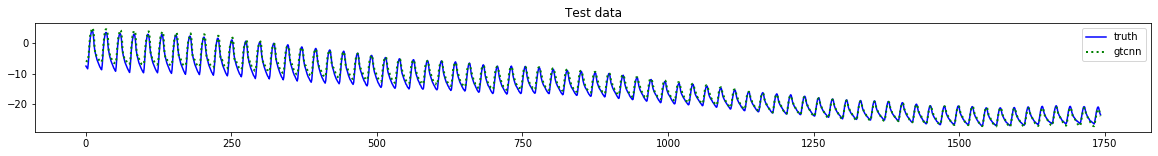

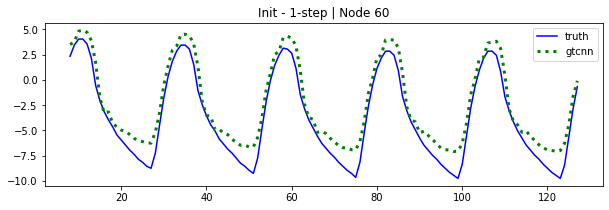

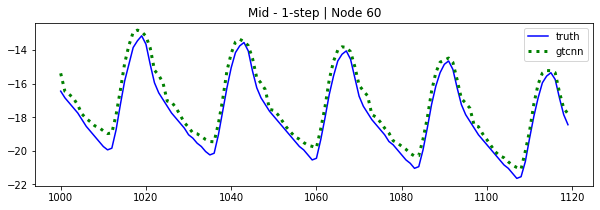

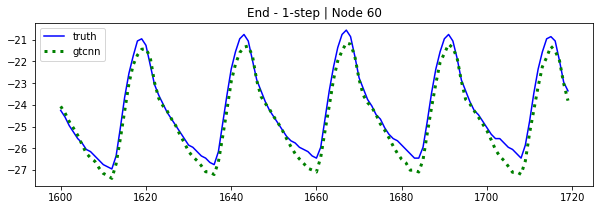

405


In [11]:
node_to_visualize = 60  # 0, 2 ,7, 13 20, 50      16   best:7
step_ahead = 1

pred = predictions_dict[step_ahead][:, node_to_visualize].cpu()
truth = tst_labels[:, step_ahead-1, node_to_visualize].cpu()
assert pred.shape == truth.shape
indices = list(range(truth.shape[0]))

truth_style = '-'
pred_style = ':'
# plot of all_data
plt.figure(figsize=(20, 2))
plt.plot(indices, truth[indices], 'b', linestyle=truth_style, label='truth')  # plotting t, a separately
plt.plot(indices, pred[indices], 'g', linestyle=pred_style, label='gtcnn', linewidth=2)  # plotting t, b separately
# plt.axvline(x=int(len(indices)* in_sample), c='g', linestyle='-')
plt.title("Test data")
plt.legend()
plt.show()


# plot of [4380:4460] indices like in elvin paper
width=120
start = 8
end = start + width
plt.figure(figsize=(10, 3))
plt.plot(indices[start:end], truth[start:end], 'b', linestyle=truth_style, label='truth')  # plotting t, a separately
plt.plot(indices[start:end], pred[start:end], 'g', linestyle=pred_style, label='gtcnn', linewidth=3)  # plotting t, b separately
# plt.axvline(x=int(len(indices)* in_sample), c='g', linestyle='-')
plt.title(f"Init - {step_ahead}-step | Node {node_to_visualize}")
plt.legend()
plt.show()


# plot of [4380:4460] indices like in elvin paper
start = 1000
end = start + width
plt.figure(figsize=(10, 3))
plt.plot(indices[start:end], truth[start:end], 'b', linestyle=truth_style, label='truth')  # plotting t, a separately
plt.plot(indices[start:end], pred[start:end], 'g', linestyle=pred_style, label='gtcnn', linewidth=3)  # plotting t, b separately
# plt.axvline(x=int(len(indices)* in_sample), c='g', linestyle='-')
plt.title(f"Mid - {step_ahead}-step | Node {node_to_visualize}")
plt.legend()
plt.show()


start = 1600
end = start + width
plt.figure(figsize=(10, 3))
plt.plot(indices[start:end], truth[start:end], 'b', linestyle=truth_style, label='truth')  # plotting t, a separately
plt.plot(indices[start:end], pred[start:end], 'g', linestyle=pred_style, label='gtcnn', linewidth=3)  # plotting t, b separately
# plt.axvline(x=int(len(indices)* in_sample), c='g', linestyle='-')
plt.title(f"End - {step_ahead}-step | Node {node_to_visualize}")
plt.legend()
plt.show()

print(epoch)

# Computing metrics

In [12]:
trn_data, val_data, tst_data, trn_labels, val_labels, tst_labels = transform_data_to_all_steps_prediction(dataset, device, order)

In [13]:
rNMSEs_trn_dict, trn_predictions = compute_iteration_rNMSE(one_step_gtcnn, steps_ahead, trn_data, trn_labels, device, verbose=False)
avg_trn_rNMSE = round(np.average(list(rNMSEs_trn_dict.values())), 5)
print(f"Average rNMSE on trn set: {avg_trn_rNMSE}")
print(f"rNMSE per step on trn set: {rNMSEs_trn_dict}")

rNMSEs_val_dict, val_predictions = compute_iteration_rNMSE(one_step_gtcnn, steps_ahead, val_data, val_labels, device, verbose=False)
avg_val_rNMSE = round(np.average(list(rNMSEs_val_dict.values())), 5)
print(f"\nAverage rNMSE on val set: {avg_val_rNMSE}")
print(f"rNMSE per step on val set: {rNMSEs_val_dict}")

rNMSEs_tst_dict, tst_predictions = compute_iteration_rNMSE(one_step_gtcnn, steps_ahead, tst_data, tst_labels, device, verbose=False)
avg_tst_rNMSE = round(np.average(list(rNMSEs_tst_dict.values())), 5)
print(f"\nAverage rNMSE on test set: {avg_tst_rNMSE}")
print(f"rNMSE per step on test set: {rNMSEs_tst_dict}")

print(model_path.split("GTCNN")[1])

print(epoch)

Average rNMSE on trn set: 0.13
rNMSE per step on trn set: {1: 0.041, 2: 0.07, 3: 0.124, 4: 0.173, 5: 0.242}

Average rNMSE on val set: 0.2802
rNMSE per step on val set: {1: 0.148, 2: 0.178, 3: 0.272, 4: 0.357, 5: 0.446}

Average rNMSE on test set: 0.1764
rNMSE per step on test set: {1: 0.079, 2: 0.117, 3: 0.162, 4: 0.234, 5: 0.29}
_lr=0.005_b=128_L=2_F=[8, 8]_T=[2, 2]_P=[2, 2]_R=[1, 1]_N=[109, 54]
405


In [14]:
BEST

True

Average rNMSE on trn set: 0.13
rNMSE per step on trn set: {1: 0.041, 2: 0.07, 3: 0.124, 4: 0.173, 5: 0.242}

Average rNMSE on val set: 0.2802
rNMSE per step on val set: {1: 0.148, 2: 0.178, 3: 0.272, 4: 0.357, 5: 0.446}

Average rNMSE on test set: 0.1764
rNMSE per step on test set: {1: 0.079, 2: 0.117, 3: 0.162, 4: 0.234, 5: 0.29}  
_lr=0.005_b=128_L=2_F=[8, 8]_T=[2, 2]_P=[2, 2]_R=[1, 1]_N=[109, 54]
405   






------------------------


Average rNMSE on trn set: 0.1584
rNMSE per step on trn set: {1: 0.045, 2: 0.078, 3: 0.149, 4: 0.218, 5: 0.302}

Average rNMSE on val set: 0.2734
rNMSE per step on val set: {1: 0.151, 2: 0.181, 3: 0.27, 4: 0.354, 5: 0.411}

Average rNMSE on test set: 0.1674
rNMSE per step on test set: {1: 0.077, 2: 0.108, 3: 0.15, 4: 0.225, 5: 0.277}   

_lr=0.005_b=128_L=2_F=[8, 8]_T=[2, 2]_P=[2, 2]_R=[1, 1]_N=[109, 54]
238

In [15]:
g_varma_rNMSEs = [0.0344, 0.0887, 0.1537, 0.2217, 0.2876]
gp_var_rNMSEs = [0.0402, 0.1013, 0.1730, 0.2487, 0.3246]

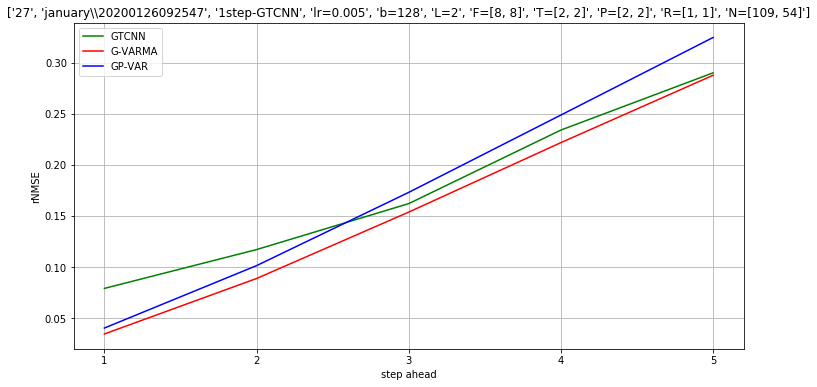

In [16]:
from matplotlib.ticker import MaxNLocator



ax = plt.figure(figsize=(12, 6)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.plot(steps_ahead, list(rNMSEs_tst_dict.values()), 'g', label='GTCNN')
plt.plot(steps_ahead, g_varma_rNMSEs, 'r', label='G-VARMA')
plt.plot(steps_ahead, gp_var_rNMSEs, 'b', label='GP-VAR')

plt.xlabel("step ahead")
plt.ylabel("rNMSE")
plt.legend()
plt.title(model_path.split("_")[4:])
plt.grid()
#plt.savefig("GTCNN_GVARMA_GPVAR_comparison.png")
plt.show()